# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

In [2]:
#@title Mount your Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/Pytorsh-CNN'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/Pytorsh-CNN'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [4]:
#@title Install dependencies

!pip install numpy==1.21.6 imageio==2.9.0 matplotlib==3.2.2

In [5]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("Pytorsh-CNN"):
  !git clone https://github.com/fadibenz/Pytorsh-CNN.git
%cd Pytorsh-CNN

/content/gdrive/My Drive/Pytorsh-CNN
/content/gdrive/My Drive/Pytorsh-CNN/Pytorsh-CNN


In [6]:
#@title Configure Jupyter Notebook

import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Train Convolutional Neural Networks using PyTorch


In [7]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils # has .data.Dataset and .data.DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

os.makedirs("submission_logs", exist_ok=True)

In [8]:
torch.cuda.is_available()
# make sure GPU is enabled

True

In [10]:
seed = 227

## Load and Visualize Data
In this cell, we load and visualize the CIFAR100 dataset. Note that we apply data augmentation (random horizontal flip) to the training dataset:
```pythontransforms.RandomHorizontalFlip()```
Data augmentation is a popular technique in machine learning and computer vision that involves generating additional training data to improve the performance of a model. One common form of data augmentation for image data is random horizontal flipping, which involves flipping an image horizontally with a 50% chance during training. This technique is often used to increase the variability of the training data and to help the model generalize better to new, unseen images. By randomly flipping images, the model is exposed to a wider range of orientations and can better learn to recognize features that are invariant to horizontal flipping.

In [11]:
valid_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),   # convert image to PyTorch Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # normalize to [-1.0, 1.0] (originally [0.0, 1.0]),
        # we are essentially doing min-max normalization, this helps
        # with guaranteeing symmetry of the input which helps with relu elbows
    ]
)

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomHorizontalFlip(),# data augmentation
    ]
)

# Download training data from open datasets.
training_data = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets.
valid_test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=valid_test_transform,
)

# split original test data to valid data and test data,
# turn into list since splitting is not supported by Pytorch's Dataset
valid_data = list(valid_test_data)[::2]
test_data = list(valid_test_data)[1::2]

classes = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "cra",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Create data loaders.
train_dataloader = utils.data.DataLoader(training_data, batch_size= 64, shuffle=True)
valid_dataloader = utils.data.DataLoader(valid_data, batch_size=5, shuffle=True)

for X, y in valid_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([5, 3, 32, 32])
Shape of y: torch.Size([5]) torch.int64


Here is a visualization of 5 images in the validation dataset:

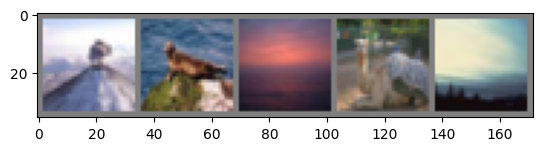

mountain   seal    sea     camel   cloud


In [ ]:
# functions to show an image
# My implementation following the Pytorsh Tutorial
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 2, 2

# for i in range (1, cols * rows +  1):
#   sample_idx = torch.randint(len(training_data), size=(1,)).item()
#   img, label = training_data[sample_idx]
#   figure.add_subplot(cols, rows, i)
#   img = img / 2 + 0.5 # Change from [-1,1] back to [0,1].
#   plt.title(classes[label])
#   plt.axis('off')

#   # imshow expects (H, W ,C)
#   plt.imshow(img.permute(1, 2, 0))
# plt.show()


# functions to show an image (Starter Code)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('   '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

## Define the Neural Network Architecture

**Complete the code in `dl_pytorch/model.py`** to finish the implementation of a convolutional neural network with batch normalization and dropout.

In [13]:
from dl_pytorch.model import NeuralNetwork

model = NeuralNetwork()
print(model)

assert len(model.state_dict()) == 10
assert model.conv1.weight.shape == torch.Size([16, 3, 3, 3])
assert model.conv1.bias.shape == torch.Size([16])
assert model.conv2.weight.shape == torch.Size([32, 16, 3, 3])
assert model.conv2.bias.shape == torch.Size([32])
assert model.conv3.weight.shape == torch.Size([64, 32, 3, 3])
assert model.conv3.bias.shape == torch.Size([64])
assert model.fc1.weight.shape == torch.Size([256, 1024])
assert model.fc1.bias.shape == torch.Size([256])
assert model.fc2.weight.shape == torch.Size([100, 256])
assert model.fc2.bias.shape == torch.Size([100])
assert model(torch.randn(9, 3, 32, 32)).shape == torch.Size([9, 100])

model = NeuralNetwork(do_batchnorm=True, p_dropout=0.1)
assert len(model.state_dict()) == 25
assert model.bn1.weight.shape == model.bn1.bias.shape == torch.Size([16])
assert model.bn2.weight.shape == model.bn2.bias.shape == torch.Size([32])
assert model.bn3.weight.shape == model.bn3.bias.shape == torch.Size([64])
assert model(torch.randn(11, 3, 32, 32)).shape == torch.Size([11, 100])

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


## Train the Neural Network

Complete the code cells below to train your neural network.

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Evaluation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [16]:
def get_optimizer(params, optim_type, lr, momentum, lr_decay, l2_reg):
    if optim_type == "sgd":
        optimizer = optim.SGD(params, lr=lr, momentum=0.0, weight_decay=l2_reg)
    elif optim_type == "sgd_momentum":
        optimizer = optim.SGD(params, lr=lr, momentum=momentum,
                              weight_decay=l2_reg)
    elif optim_type == "adam":
        optimizer = optim.AdamW(params, lr=lr, betas=(momentum, 0.999),
                                weight_decay=l2_reg)
    else:
        raise ValueError(optim_type)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    return optimizer, scheduler

Train the neural network. It should achieve at least 35% accuracy on the test set.

In [17]:
def run_training(hp, nn_cls, save_prefix):
    print("Hyperparameters:", hp)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    model = nn_cls(do_batchnorm=hp.do_batchnorm, p_dropout=hp.p_dropout).cuda()

    # Create data loaders.
    train_dataloader = utils.data.DataLoader(
        training_data, batch_size=hp.batch_size)
    valid_dataloader = utils.data.DataLoader(
        valid_data, batch_size=hp.batch_size)

    loss_fn = nn.CrossEntropyLoss()
    optimizer, scheduler = get_optimizer(
        model.parameters(), hp.optim_type, hp.lr, hp.momentum, hp.lr_decay,
        hp.l2_reg)

    for t in range(hp.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(valid_dataloader, model, loss_fn)
        scheduler.step()

    print(f"Saving the model to submission_logs/{save_prefix}.pt")
    torch.save(model.state_dict(), f"submission_logs/{save_prefix}.pt")
    return model

def eval_on_test(hp, model, save_prefix):
    train_dataloader = utils.data.DataLoader(
        training_data, batch_size=hp.batch_size)
    test_dataloader = utils.data.DataLoader(
        test_data, batch_size=hp.batch_size)
    loss_fn = nn.CrossEntropyLoss()
    print("Evaluating on the test set")
    test_acc = test(test_dataloader, model, loss_fn)
    n_params = sum(p.numel() for p in model.parameters())
    print("Parameter count: {}".format(n_params))
    n_steps = len(train_dataloader) * hp.epochs
    print("Training steps: {}".format(n_steps))
    with open(f"submission_logs/{save_prefix}.json", "w", encoding="utf-8") as f:
        json.dump({
            "test_acc": test_acc,
            "hparams": hp.__dict__,
            "n_params": n_params,
            "n_steps": n_steps
        }, f)

In [43]:
from dl_pytorch.hparams import HP as hp_base

model = run_training(hp_base, NeuralNetwork, "model")
eval_on_test(hp_base, model, "model")

Hyperparameters: Namespace(batch_size=32, lr=0.001, momentum=0.9, lr_decay=0.99, optim_type='adam', l2_reg=0.0, epochs=5, do_batchnorm=False, p_dropout=0.0)
Epoch 1
-------------------------------
loss: 4.607782  [    0/50000]
loss: 4.329588  [ 3200/50000]
loss: 4.099283  [ 6400/50000]
loss: 3.816479  [ 9600/50000]
loss: 3.841524  [12800/50000]
loss: 4.398440  [16000/50000]
loss: 3.298751  [19200/50000]
loss: 3.986940  [22400/50000]
loss: 3.329582  [25600/50000]
loss: 3.682697  [28800/50000]
loss: 3.240136  [32000/50000]
loss: 3.477612  [35200/50000]
loss: 3.280922  [38400/50000]
loss: 3.441875  [41600/50000]
loss: 2.650690  [44800/50000]
loss: 3.187408  [48000/50000]
Evaluation Error: 
 Accuracy: 23.5%, Avg loss: 3.133029 

Epoch 2
-------------------------------
loss: 3.151052  [    0/50000]
loss: 3.414325  [ 3200/50000]
loss: 3.368143  [ 6400/50000]
loss: 3.024598  [ 9600/50000]
loss: 2.797662  [12800/50000]
loss: 3.511456  [16000/50000]
loss: 2.800680  [19200/50000]
loss: 3.430162 

In [44]:
from dl_pytorch.hparams_bn_drop import HP as hp_bn_drop

model = run_training(hp_bn_drop, NeuralNetwork, "model_bn_drop")
eval_on_test(hp_bn_drop, model, "model_bn_drop")

Hyperparameters: Namespace(batch_size=32, lr=0.001, momentum=0.9, lr_decay=0.99, optim_type='adam', l2_reg=0.0, epochs=5, do_batchnorm=True, p_dropout=0.2)
Epoch 1
-------------------------------
loss: 4.662846  [    0/50000]
loss: 4.114068  [ 3200/50000]
loss: 3.879408  [ 6400/50000]
loss: 3.589612  [ 9600/50000]
loss: 3.272174  [12800/50000]
loss: 3.711957  [16000/50000]
loss: 3.121399  [19200/50000]
loss: 3.662117  [22400/50000]
loss: 3.215035  [25600/50000]
loss: 3.494321  [28800/50000]
loss: 3.178165  [32000/50000]
loss: 2.939664  [35200/50000]
loss: 2.762621  [38400/50000]
loss: 3.113016  [41600/50000]
loss: 3.026769  [44800/50000]
loss: 2.846575  [48000/50000]
Evaluation Error: 
 Accuracy: 29.7%, Avg loss: 2.806186 

Epoch 2
-------------------------------
loss: 3.229989  [    0/50000]
loss: 3.013874  [ 3200/50000]
loss: 3.279917  [ 6400/50000]
loss: 2.794817  [ 9600/50000]
loss: 2.387193  [12800/50000]
loss: 2.969257  [16000/50000]
loss: 2.740277  [19200/50000]
loss: 3.070149  

## Design your own neural network


It's time to showcase your deep learning skills! In this assignment, you will be designing your own neural network using PyTorch. Your task is to **implement your neural network design in the files `dl_pytorch/my_model.py` and `dl_pytorch/hparams_my_model.py`**. The goal is to achieve a test accuracy of **44%** or higher.

To ensure reproducibility and to maintain the focus of the assignment, please adhere to the following rules:

1. Do not modify the code in the Jupyter Notebook cell or other cells that this cell depends on. It means that you cannot change data processing, the training loop, and the random seed. The emphasis of this assignment is on the model architecture and hyperparameter tuning.

1. The number of model parameters must not exceed `1,000,000`.

1. The total number of training steps should be no more than `20,000`.

1. The maximum number of training epochs is `10`.

1. Please refrain from using any pre-trained models or other downloaded assets.

Your test accuracy will be displayed on the Gradescope leaderboard. Please note that your rank on the leaderboard does not affect your grade. In order to receive full credit for this part of the assignment, you only need to abide by the rules outlined above and achieve a minimum test accuracy of 44%. Your grade will be scaled linearly, with a score of 0 for a test accuracy of 38% and full credit for a test accuracy of 44% or higher.

In [36]:
from dl_pytorch.my_model import MyNeuralNetwork
from dl_pytorch.hparams_my_model import HP as hp_my_model

model = run_training(hp_my_model, MyNeuralNetwork, "model_my_model")

Hyperparameters: Namespace(batch_size=128, lr=0.002, momentum=0.9, lr_decay=0.95, optim_type='adam', l2_reg=0.0, epochs=10, do_batchnorm=True, p_dropout=0.2)
Epoch 1
-------------------------------
loss: 4.679676  [    0/50000]
loss: 3.326557  [12800/50000]
loss: 2.558361  [25600/50000]
loss: 2.520237  [38400/50000]
Evaluation Error: 
 Accuracy: 34.9%, Avg loss: 2.547977 

Epoch 2
-------------------------------
loss: 2.550080  [    0/50000]
loss: 2.347459  [12800/50000]
loss: 2.033722  [25600/50000]
loss: 1.910624  [38400/50000]
Evaluation Error: 
 Accuracy: 41.3%, Avg loss: 2.269233 

Epoch 3
-------------------------------
loss: 2.222437  [    0/50000]
loss: 1.992286  [12800/50000]
loss: 1.799487  [25600/50000]
loss: 1.814539  [38400/50000]
Evaluation Error: 
 Accuracy: 45.5%, Avg loss: 2.106189 

Epoch 4
-------------------------------
loss: 1.851951  [    0/50000]
loss: 1.753968  [12800/50000]
loss: 1.645844  [25600/50000]
loss: 1.477895  [38400/50000]
Evaluation Error: 
 Accuracy

In [37]:
# When you are ready to eval on test set, run this cell
# WARNING: In real-world applications, it is a bad practice to evaluate
#          frequently on the test set because the model will then perform poorly
#          on new, unseen data even if it achieves a high test accuracy.
eval_on_test(hp_my_model, model, "model_my_model")

Evaluating on the test set
Evaluation Error: 
 Accuracy: 53.2%, Avg loss: 1.821630 

Parameter count: 859552
Training steps: 3910


For my implementation, I started by deciding the largest batch size possible I can use to stabilize training as I noticed flactuations in the loss. Afterwards, I started experimenting with the final connected layer as I thought we might be extracting enough features but the width of the final FCN was not enough to infer the 100 classes. I experemented with diffrent widths/depths and the best performance was given by two-layer FCN with width of 356 (Increased from 256). I added afterwards an l2 regualrization of 1e-3 to combat overfitting, which helped in having a test accuracy more than training accuracy.  For the convolutional layers I increased the number of filters to extract more features as distinguishing between 100 classes needs many more features, I increased the number of channels as we got deeper, as more complex patterns at later layers of the convNet need more features (channels).



## Important:
1. Adding batch in the FNC improved perfromance drastically.
2. Even with no l2 regularization I had no overfitting since I'm using both dropout and BN.
3. I should experiment with weight decay and lr.
4. using max-pool instead of stride, proved to yield way better results for the last layer.